In [1]:
import gurobipy as gp
from gurobipy import GRB
import random
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import warnings
from tqdm import tqdm_notebook as tqdm
import requests
import json
import API
import matplotlib.pyplot as plt
import GoogleDistanceMatrix
import GoogleVRP
import routing
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
warnings.filterwarnings('ignore')

## modelling

In [2]:
order = pd.read_csv('Data/ProcessedJun29.csv')

In [3]:
order['門店名稱'].unique()

array(['PHD629', 'PH64', 'PH57', 'PHD606'], dtype=object)

In [4]:
phdstore = 'PHD606'
phstore = 'PH64'

In [5]:
order = order.loc[order['門店名稱'].isin([phdstore,phstore])]
order.shape

(411, 30)

In [6]:
order['foodPreparationTime'] = pd.to_datetime(order['取餐出發時間']) - pd.to_datetime(order['下單時間'])

In [7]:
order = order[['orderTime', 'arrivalTime', 'foodPreparationTime','waitingTime', 'departureTime', 'tripDurationReal',
       'DeliveryLatLon', 'storeCode', 'StoreLatLon',
       'tripDurationFromGoogle', 'shared','Rider','timeParameter']]

In [8]:
order = order.dropna()

In [76]:
order.shape

(411, 13)

In [77]:
order['tripDurationFromGoogle'] = order['tripDurationFromGoogle'] + 240

In [9]:
slot = 5
order['departureTime'] = pd.to_datetime(order['departureTime'])
order['hour'] = order['departureTime'].dt.hour
order['min'] = order['departureTime'].dt.minute
order['min'] = order['min'].apply(lambda x: (int(x/slot)+1)*slot)

order.loc[order['min']==60,'hour'] = order.loc[order['min']==60,'hour']+1
order.loc[order['min']==60,'min'] = 0

In [14]:
order['date'] = order['departureTime'].dt.date
countdf = order.groupby(['date','hour','min']).count()[['orderTime']].rename(columns={'orderTime':'count'}).reset_index()
countdf

,date,hour,min,count
0,2020-06-29,11,45,1
1,2020-06-29,12,10,1
2,2020-06-29,12,15,1
3,2020-06-29,12,25,1
4,2020-06-29,13,20,1
5,2020-06-29,13,45,1
6,2020-06-29,17,35,1
7,2020-06-29,18,15,2
8,2020-06-29,18,35,1
9,2020-06-29,18,55,1


In [53]:
countdf.sum()

hour     3857
min      6535
count     411
dtype: int64

In [59]:
countdf['hour'].unique()

array([11, 12, 13, 17, 18, 19, 20, 21, 22, 14, 16, 15])

In [67]:
date = np.repeat(countdf.date.unique(),len(range(11,23))*len(np.arange(0,60,5)))
hour = np.repeat(range(11,23),12*6)
minute = np.tile(np.arange(0,60,5),12*6)
complete = pd.DataFrame({'date':date,'hour':hour,'min':minute})

In [82]:
griddf = countdf.merge(complete,on=['date','hour','min'],how='outer').fillna(0).drop_duplicates()
griddf = pd.pivot_table(griddf,index='date',values='count',columns=['hour','min']).fillna(0)
# griddf.sum()

In [116]:
len(np.repeat(data,5,axis=0)[0])

720

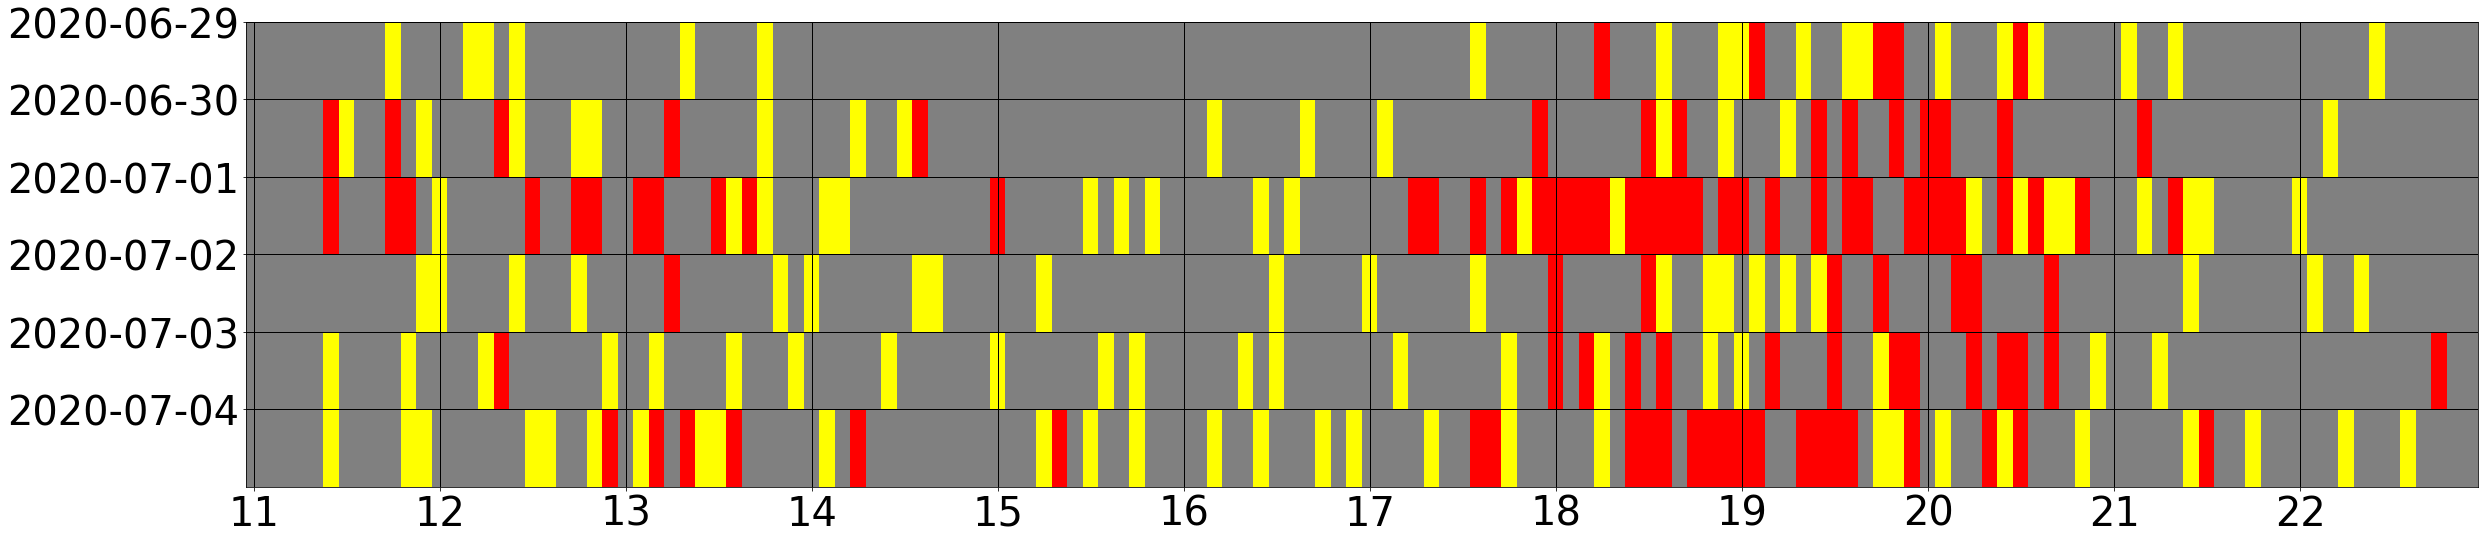

In [131]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

data = griddf.values
data = np.repeat(data,5,axis=0)
# create discrete colormap
cmap = colors.ListedColormap(['grey','yellow', 'red'])
bounds = [0,1,2,6]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(40,40))
ax.imshow(data, cmap=cmap, norm=norm)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
# ax.set_xticks(range(len(data[0])),np.repeat(range(11,23),12));
# ax.set_yticks(np.arange(-.5, 10, 1));

plt.xticks(np.arange(0, 144, 12),range(11,23),fontsize=40)
plt.yticks(np.arange(-0.5, 29.5, 5),order['date'].unique(),fontsize=40)
# plt.show()
# plt.draw()
plt.savefig('grid.png',bbox_inches='tight',dpi=150,figsize=(40,40))

In [124]:
data.shape

(30, 144)

In [109]:
np.arange(0, 6, 1)

array([0, 1, 2, 3, 4, 5])

In [110]:
np.arange(0, 30, 5)

array([ 0,  5, 10, 15, 20, 25])

In [ ]:
order['date'].unique()

In [90]:
len(np.repeat(range(11,23),12))

144

In [47]:
colors.BoundaryNorm?

In [43]:
norm.values

AttributeError: 'BoundaryNorm' object has no attribute 'values'

In [79]:
order['timeWindow'] = pd.Timedelta('0 days 00:45:00') - order['foodPreparationTime']
order['timeWindow'] = order['timeWindow'].dt.seconds


In [80]:
order['timeParameter'] = order['tripDurationReal']/order['tripDurationFromGoogle']
order['timeParameter'] = order['timeParameter'].median()

In [81]:
order['date'] = pd.to_datetime(order['orderTime']).dt.date

In [82]:
# dispatch immediately
order['timeWindow'] = order['timeWindow'] /order['timeParameter']
order['timeWindow'] = order['tripDurationFromGoogle']+240

In [49]:
# slot aggregation
order['timeWindow'] = order['timeWindow'] /order['timeParameter']
order.loc[order['timeWindow'] < order['tripDurationFromGoogle'],'timeWindow'] = \
order.loc[order['timeWindow'] < order['tripDurationFromGoogle'],'tripDurationFromGoogle']

In [83]:
rider_df = order.groupby(['date']).agg({'Rider':'unique'}).reset_index()
rider_df['Date'] = pd.to_datetime(rider_df['date']).dt.day

In [84]:
PHDLatLon = order.loc[order['storeCode']==phdstore]['StoreLatLon'].values[0]
PHLatLon = order.loc[order['storeCode']==phstore]['StoreLatLon'].values[0]


In [85]:
PHDLatLon

'22.284361999999998,114.13979259999999'

In [86]:
PHLatLon

'22.284392699999998,114.141973'

In [87]:
order['tripTime'] = 0
order['rider'] = 0

In [88]:
PHD_output = pd.DataFrame()
PH_output = pd.DataFrame()

In [89]:
order['tripTime'] = 0
order['rider'] = 0
order['delayed'] = 0
order['departureTimeSimulation'] = pd.to_datetime(order.orderTime).dt.date.astype(str)+' '+order['hour'].apply(lambda x:str(x).zfill(2))+\
                                        ':'+order['min'].apply(lambda x:str(x).zfill(2))+':00'
candidate_output = pd.DataFrame()
# PH_output = pd.DataFrame()

In [90]:
order.shape

(411, 21)

In [91]:
location = str((22.284361999999998+22.284392699999998)/2)+','+str((114.13979259999999+114.141973)/2)
location

'22.28437735,114.14088279999999'

In [92]:
for day in [29,30,1,2,3,4]:
    if day > 5:
        month = '06'
    else:
        month = '07'
    day = str(day).zfill(2)
    # reset riders
    riders = rider_df.loc[rider_df['date']==pd.to_datetime('2020-%s-%s'%(month,day))]['Rider'].values[0].tolist()
    riderStatus = {}
    for i in (riders):
        riderStatus[i] = 0
    for hour in range(11,24):
        for minute in np.arange(0,59,slot).tolist()+[59]:
            print(day,hour,minute)
            # update rider status at current time
            for key in riderStatus.keys():
                if riderStatus[key]!= 0:
                    if riderStatus[key] <= pd.to_datetime('2020-%s-%s %s:%s:00'%(month,day,hour,str(minute).zfill(2))):
                        riderStatus[key] = 0

            candidate = order.loc[(pd.to_datetime(order['orderTime']).dt.date.astype(str)=='2020-%s-%s'%(month,day))&(order['hour']==hour)&(order['min']==minute)]
            if len(candidate) > 0:
                print(len(candidate))
#                 PHD = candidate.loc[candidate['storeCode']==phdstore]
#                 PH = candidate.loc[candidate['storeCode']==phstore]
                timeParameter = order.loc[(order['hour']==hour)&(order['min']==minute)]['timeParameter'].unique()[0]
#                 print('PHD',len(PHD))
                candidate_output,riderStatus,order = routing.tripAssign(month,day,hour,minute,timeParameter,candidate, location, riderStatus,order,candidate_output)
                print(len(candidate))
#                 PHD_output,riderStatus,order = routing.tripAssign(month,day,hour,minute,timeParameter,PHD, PHDLatLon, riderStatus,order,PHD_output)
#                 print('PH',len(PH))
#                 PH_output,riderStatus,order = routing.tripAssign(month,day,hour,minute,timeParameter,PH, PHLatLon, riderStatus,order,PH_output)

                

29 11 0
29 11 1
29 11 2
29 11 3
29 11 4
29 11 5
29 11 6
29 11 7
29 11 8
29 11 9
29 11 10
29 11 11
29 11 12
29 11 13
29 11 14
29 11 15
29 11 16
29 11 17
29 11 18
29 11 19
29 11 20
29 11 21
29 11 22
29 11 23
29 11 24
29 11 25
29 11 26
29 11 27
29 11 28
29 11 29
29 11 30
29 11 31
29 11 32
29 11 33
29 11 34
29 11 35
29 11 36
29 11 37
29 11 38
29 11 39
29 11 40
29 11 41
29 11 42
1
1
29 11 43
29 11 44
29 11 45
29 11 46
29 11 47
29 11 48
29 11 49
29 11 50
29 11 51
29 11 52
29 11 53
29 11 54
29 11 55
29 11 56
29 11 57
29 11 58
29 11 59
29 12 0
29 12 1
29 12 2
29 12 3
29 12 4
29 12 5
29 12 6
29 12 7
29 12 8
29 12 9
1
1
29 12 10
29 12 11
1
1
29 12 12
29 12 13
29 12 14
29 12 15
29 12 16
29 12 17
29 12 18
29 12 19
29 12 20
29 12 21
29 12 22
29 12 23
29 12 24
1
1
29 12 25
29 12 26
29 12 27
29 12 28
29 12 29
29 12 30
29 12 31
29 12 32
29 12 33
29 12 34
29 12 35
29 12 36
29 12 37
29 12 38
29 12 39
29 12 40
29 12 41
29 12 42
29 12 43
29 12 44
29 12 45
29 12 46
29 12 47
29 12 48
29 12 49
29 12 50
29 12

2
30 13 13
30 13 14
30 13 15
30 13 16
30 13 17
30 13 18
30 13 19
30 13 20
30 13 21
30 13 22
30 13 23
30 13 24
30 13 25
30 13 26
30 13 27
30 13 28
30 13 29
30 13 30
30 13 31
30 13 32
30 13 33
30 13 34
30 13 35
30 13 36
30 13 37
30 13 38
30 13 39
30 13 40
30 13 41
30 13 42
30 13 43
1
1
30 13 44
30 13 45
30 13 46
30 13 47
30 13 48
30 13 49
30 13 50
30 13 51
30 13 52
30 13 53
30 13 54
30 13 55
30 13 56
30 13 57
30 13 58
30 13 59
30 14 0
30 14 1
30 14 2
30 14 3
30 14 4
30 14 5
30 14 6
30 14 7
30 14 8
30 14 9
30 14 10
30 14 11
1
1
30 14 12
30 14 13
30 14 14
30 14 15
30 14 16
30 14 17
30 14 18
30 14 19
30 14 20
30 14 21
30 14 22
30 14 23
30 14 24
30 14 25
30 14 26
30 14 27
30 14 28
30 14 29
1
1
30 14 30
30 14 31
30 14 32
30 14 33
30 14 34
2
2
30 14 35
30 14 36
30 14 37
30 14 38
30 14 39
30 14 40
30 14 41
30 14 42
30 14 43
30 14 44
30 14 45
30 14 46
30 14 47
30 14 48
30 14 49
30 14 50
30 14 51
30 14 52
30 14 53
30 14 54
30 14 55
30 14 56
30 14 57
30 14 58
30 14 59
30 15 0
30 15 1
30 15 2
30 15

01 15 26
01 15 27
01 15 28
01 15 29
01 15 30
1
1
01 15 31
01 15 32
01 15 33
01 15 34
01 15 35
01 15 36
01 15 37
01 15 38
1
1
01 15 39
01 15 40
01 15 41
01 15 42
01 15 43
01 15 44
01 15 45
01 15 46
01 15 47
1
1
01 15 48
01 15 49
01 15 50
01 15 51
01 15 52
01 15 53
01 15 54
01 15 55
01 15 56
01 15 57
01 15 58
01 15 59
01 16 0
01 16 1
01 16 2
01 16 3
01 16 4
01 16 5
01 16 6
01 16 7
01 16 8
01 16 9
01 16 10
01 16 11
01 16 12
01 16 13
01 16 14
01 16 15
01 16 16
01 16 17
01 16 18
01 16 19
01 16 20
01 16 21
01 16 22
01 16 23
01 16 24
01 16 25
1
1
01 16 26
01 16 27
01 16 28
01 16 29
01 16 30
01 16 31
01 16 32
01 16 33
01 16 34
1
1
01 16 35
01 16 36
01 16 37
01 16 38
01 16 39
01 16 40
01 16 41
01 16 42
01 16 43
01 16 44
01 16 45
01 16 46
01 16 47
01 16 48
01 16 49
01 16 50
01 16 51
01 16 52
01 16 53
01 16 54
01 16 55
01 16 56
01 16 57
01 16 58
01 16 59
01 17 0
01 17 1
01 17 2
01 17 3
01 17 4
01 17 5
01 17 6
01 17 7
01 17 8
01 17 9
01 17 10
01 17 11
01 17 12
1
1
01 17 13
1
1
01 17 14
01 17 15
01

02 18 22
02 18 23
02 18 24
02 18 25
02 18 26
02 18 27
02 18 28
02 18 29
02 18 30
2
2
02 18 31
02 18 32
1
1
02 18 33
02 18 34
02 18 35
02 18 36
02 18 37
02 18 38
02 18 39
02 18 40
02 18 41
02 18 42
02 18 43
02 18 44
02 18 45
02 18 46
02 18 47
1
1
02 18 48
02 18 49
02 18 50
02 18 51
02 18 52
1
1
02 18 53
02 18 54
02 18 55
02 18 56
02 18 57
02 18 58
02 18 59
02 19 0
02 19 1
02 19 2
1
1
02 19 3
02 19 4
02 19 5
02 19 6
02 19 7
02 19 8
02 19 9
02 19 10
02 19 11
02 19 12
02 19 13
02 19 14
02 19 15
1
1
02 19 16
02 19 17
02 19 18
02 19 19
02 19 20
02 19 21
1
1
02 19 22
02 19 23
02 19 24
02 19 25
02 19 26
02 19 27
02 19 28
1
1
02 19 29
3
3
02 19 30
02 19 31
02 19 32
02 19 33
02 19 34
02 19 35
02 19 36
02 19 37
02 19 38
02 19 39
02 19 40
02 19 41
02 19 42
02 19 43
1
1
02 19 44
02 19 45
1
1
02 19 46
02 19 47
02 19 48
02 19 49
02 19 50
02 19 51
02 19 52
02 19 53
02 19 54
02 19 55
02 19 56
02 19 57
02 19 58
02 19 59
02 20 0
02 20 1
02 20 2
02 20 3
02 20 4
02 20 5
02 20 6
02 20 7
02 20 8
1
1
02 20 9


03 20 27
03 20 28
2
2
03 20 29
03 20 30
03 20 31
03 20 32
03 20 33
03 20 34
03 20 35
03 20 36
03 20 37
03 20 38
03 20 39
03 20 40
2
2
03 20 41
03 20 42
03 20 43
03 20 44
03 20 45
03 20 46
03 20 47
03 20 48
03 20 49
03 20 50
03 20 51
03 20 52
1
1
03 20 53
03 20 54
03 20 55
03 20 56
03 20 57
03 20 58
03 20 59
03 21 0
03 21 1
03 21 2
03 21 3
03 21 4
03 21 5
03 21 6
03 21 7
03 21 8
03 21 9
03 21 10
03 21 11
03 21 12
03 21 13
03 21 14
1
1
03 21 15
03 21 16
03 21 17
03 21 18
03 21 19
03 21 20
03 21 21
03 21 22
03 21 23
03 21 24
03 21 25
03 21 26
03 21 27
03 21 28
03 21 29
03 21 30
03 21 31
03 21 32
03 21 33
03 21 34
03 21 35
03 21 36
03 21 37
03 21 38
03 21 39
03 21 40
03 21 41
03 21 42
03 21 43
03 21 44
03 21 45
03 21 46
03 21 47
03 21 48
03 21 49
03 21 50
03 21 51
03 21 52
03 21 53
03 21 54
03 21 55
03 21 56
03 21 57
03 21 58
03 21 59
03 22 0
03 22 1
03 22 2
03 22 3
03 22 4
03 22 5
03 22 6
03 22 7
03 22 8
03 22 9
03 22 10
03 22 11
03 22 12
03 22 13
03 22 14
03 22 15
03 22 16
03 22 17
03 22

04 23 11
04 23 12
04 23 13
04 23 14
04 23 15
04 23 16
04 23 17
04 23 18
04 23 19
04 23 20
04 23 21
04 23 22
04 23 23
04 23 24
04 23 25
04 23 26
04 23 27
04 23 28
04 23 29
04 23 30
04 23 31
04 23 32
04 23 33
04 23 34
04 23 35
04 23 36
04 23 37
04 23 38
04 23 39
04 23 40
04 23 41
04 23 42
04 23 43
04 23 44
04 23 45
04 23 46
04 23 47
04 23 48
04 23 49
04 23 50
04 23 51
04 23 52
04 23 53
04 23 54
04 23 55
04 23 56
04 23 57
04 23 58
04 23 59


In [93]:
candidate_output.shape

(411, 21)

In [96]:
output = candidate_output

In [94]:
output = pd.concat([PHD_output,PH_output])

In [97]:
output.shape

(411, 21)

In [98]:
output['arrivalTimeSimulation'] = pd.to_datetime(output['departureTimeSimulation']) +\
                                        pd.to_timedelta(output['tripTime'],'seconds')
output['waitingTimeSimulation'] = output['arrivalTimeSimulation'] - pd.to_datetime(output['orderTime'])
output['waitingTimeReal'] = pd.to_datetime(output['arrivalTime']) - pd.to_datetime(output['orderTime'])


In [99]:
output['waitingTimeSimulation'].mean()

Timedelta('0 days 00:37:03.069707')

In [100]:
output['waitingTimeReal'].mean()

Timedelta('0 days 00:42:01.554744')

In [101]:
len(output.loc[output['rider']=='3rd'])

0

In [102]:
output.to_csv('Output/order64_606_1min_immediately_2stores_7013.csv',index=False)